# Load Data and Display Samples

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Check if the current working directory is the notebooks directory
if 'notebooks' in os.path.basename(os.getcwd()):
    # Change directory to the parent of notebooks
    %cd ..
    print("Changed working directory to the project root:", os.getcwd())
else:
    print("Working directory:", os.getcwd())

c:\Users\sghys\My Drive (sghyseli@student.ubc.ca)\ComputerVision
Changed working directory to the project root: c:\Users\sghys\My Drive (sghyseli@student.ubc.ca)\ComputerVision


## Load Data

The data is being stored in pickle files. They are from Python2 era and the strings are stored as bytecode. The unpickle function in the data directory addresses the proper conversion of these values over to strings. The data is in 5 batches as follows:

*data* -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

*labels* -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

---

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

*label_names* -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

Shape of images: (50000, 32, 32, 3)
Shape of labels: 50000


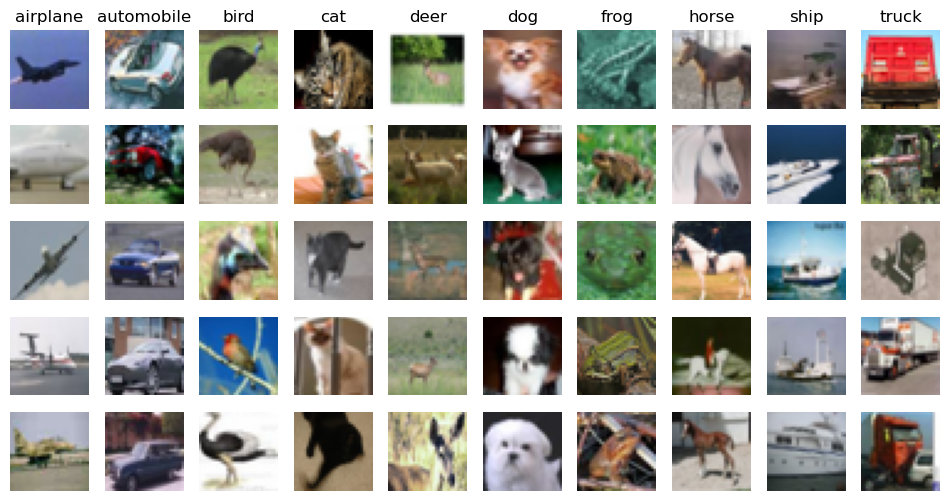

In [2]:
from utils.load_data import load_cifar10

data, labels, data_test, labels_test, label_names = load_cifar10()

# Reshaping the data to a more manageable format (10000, 32, 32, 3)
images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
images_test = data_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Verifying the shape of images and labels
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {len(labels)}")

# Number of classes and number of samples per class to display
num_classes = 10
samples_per_class = 5

# show some examples of each class to make sure the data is correct
plt.figure(figsize=(12, 6))
for cls in range(num_classes):
    idxs = [i for i, lbl in enumerate(labels) if lbl == cls]
    random_idxs = random.sample(idxs, samples_per_class)
    
    for i, idx in enumerate(random_idxs):
        # Calculate the position of the subplot
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            # Label only the first row
            plt.title(label_names[cls])

plt.show()


## Bag of Words (Descriptors) Model

Strategy: Use SIFT to extract features from the image set and build a histogram for each image. Train a linear regression model on the extracted features. Below are some trials for Logistic regression and softmax, as well as an attempt made with SVM to compare the two.

In [3]:
from models.bag_of_descriptors import BagOfDescriptors as BoD
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model with L2 regularization with C controling variance of prior
reg_model = LogisticRegression(penalty='l2', C=5.0, multi_class='multinomial', solver='lbfgs', max_iter=5000)
# Create a BoD model with clusters and the logistic regression model
model = BoD(clusters = 200, regression_model = reg_model)

# Train the model on the first n images
n_images = 10000
model.fit(images[0:n_images], labels[0:n_images])


Training on 104236 descriptors
KMeans trained with 150 clusters
Features extracted for 9975 images


In [4]:
# Select a subset of validation images by slicing the last 1000
# from the training set (assumes full training set not used above)
n_val_images = 1000
X_val = images[-n_val_images:]
y_val = labels[-n_val_images:]

# Get predictions as probability vectors
probability_vectors = model.predict(X_val)

# Initialize arrays to store the predicted classes and their probabilities
predicted_classes = []
predicted_probabilities = []

# Iterate over each probability vector
for prob_vector in probability_vectors:
    # Find the index of the maximum probability
    class_index = np.argmax(prob_vector)
    predicted_classes.append(class_index)
    
    # Find the value of the maximum probability
    max_probability = prob_vector[class_index]
    predicted_probabilities.append(max_probability)
    
# Convert the lists to numpy arrays
predicted_classes = np.array(predicted_classes)
predicted_probabilities = np.array(predicted_probabilities)

# calculate the accuracy of the model
accuracy = np.mean(predicted_classes == y_val)
print(f"Accuracy of the model: {accuracy}")
    



Accuracy of the model: 0.231


In [5]:
from sklearn.svm import SVC
from models.bag_of_descriptors import BagOfDescriptors as BoD

# Create an SVM model with a radial basis function kernel and L2 regularization with C controling variance of prior
svm_model = SVC(kernel='linear', C=5.0, probability=True)  # 'probability=True' is needed for predict_proba

# Create a BoD model with 200 clusters and the SVM model
model = BoD(clusters=200, regression_model=svm_model)

# Train the model on the first n images
n_images = 10000
model.fit(images[0:n_images], labels[0:n_images])

# Select a subset of validation images by slicing the last 1000
# from the training set (assumes full training set not used above)
n_val_images = 1000
X_val = images[-n_val_images:]
y_val = labels_test[-n_val_images:]

# Get predictions as probability vectors
probability_vectors = model.predict(X_val)

# Initialize arrays to store the predicted classes and their probabilities
predicted_classes = []
predicted_probabilities = []

# Iterate over each probability vector
for prob_vector in probability_vectors:
    # Find the index of the maximum probability
    class_index = np.argmax(prob_vector)
    predicted_classes.append(class_index)
    
    # Find the value of the maximum probability
    max_probability = prob_vector[class_index]
    predicted_probabilities.append(max_probability)
    
# Convert the lists to numpy arrays
predicted_classes = np.array(predicted_classes)
predicted_probabilities = np.array(predicted_probabilities)

# Calculate the accuracy of the model
accuracy = np.mean(predicted_classes == y_val)
print(f"Accuracy of the model: {accuracy}")


Training on 104236 descriptors
KMeans trained with 200 clusters


KeyboardInterrupt: 

The SVM takes a longer time to compute with RBF and with linear kernel based on some preliminary training exploration. It gives 26% accurracy after training on 10000 image subset. The RBF kernel doesn't help for the histogram based features.  In light of this it might be preferable to stick with the Logistic Regression model.